# Training Models

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import gcsfs
fs = gcsfs.GCSFileSystem()
import os
import cftime

## Load Data 

In [2]:
from utils import load_vars_xarray, split_input_output

In [3]:
def list_all_vars():
    mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
    ds = xr.open_dataset(mapper, engine='zarr')
    all_input_vars = list(ds.data_vars)[:-2]
    
    mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
    ds = xr.open_dataset(mapper, engine='zarr')
    all_output_vars = list(ds.data_vars)[:-2]
    return(all_input_vars, all_output_vars)

i, o = list_all_vars()
print(o)

['cam_out_FLWDS', 'cam_out_NETSW', 'cam_out_PRECC', 'cam_out_PRECSC', 'cam_out_SOLL', 'cam_out_SOLLD', 'cam_out_SOLS', 'cam_out_SOLSD', 'state_q0001', 'state_q0002', 'state_q0003', 'state_t', 'state_u', 'state_v']


In [4]:
# same variables as VED paper

input_vars = 'state_q0001 state_t pbuf_SOLIN pbuf_LHFLX pbuf_SHFLX state_ps'.split() # humidity, temp, solar insolation, latent and sensible heat, surface pressure
output_vars = ['state_q0001', 'state_t', 'cam_out_NETSW', 'cam_out_FLWDS']


In [5]:
ds = load_vars_xarray(input_vars, output_vars, downsample=True, chunks = True)
ds

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "sample" starting at index 720. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Daily average


<xarray.Dataset>
Dimensions:            (time: 2920, lev: 60, ncol: 384)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 ... 378 379 380 381 382 383
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
    lon                (ncol) float64 320.3 331.5 320.4 ... 123.3 146.7 135.0
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    state_t            (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    pbuf_SOLIN         (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    pbuf_LHFLX         (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    pbuf_SHFLX         (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    state_ps           (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    out_state_q0001    (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    out_state_t        (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    out_cam_out_NETSW  (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    out_cam_out_FLWDS  (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [6]:
from dask.diagnostics import ProgressBar

# visualize with progress bar
# use .load() or .compute() to do the math and get the daily mean data

with ProgressBar():
    ds.load()

[########################################] | 100% Completed | 24m 1ss


In [7]:
ds.nbytes / 1e9

2.206711616

In [9]:
def select_region(condition):
    # assumes condition is a lambda function taking in a lat and lon
    # returns the indices for which this is true
    lat, lon = ds.lat.values, ds.lon.values
    latlon = pd.DataFrame({"lat" : lat, "lon": lon})
    return(list(latlon[latlon.apply(condition, axis=1)].index)) # the indices of the matching latlons

def split_ds_by_area(ds, condition):
    match = select_region(condition)
    unmatch = select_region(lambda row : not condition(row))
    return(ds.isel(ncol=match), ds.isel(ncol=unmatch))

In [10]:
train, test = split_ds_by_area(ds, lambda row : abs(row.lat) < 45)

In [11]:
train

<xarray.Dataset>
Dimensions:            (time: 2920, lev: 60, ncol: 264)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 ... 306 319 320 333 370 383
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... 40.39 40.39 40.39
    lon                (ncol) float64 320.3 331.5 320.4 ... 45.0 225.0 135.0
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 1.488e-06 ... 0.003413
    state_t            (time, lev, ncol) float64 216.6 218.0 ... 283.5 275.4
    pbuf_SOLIN         (time, ncol) float64 477.9 475.6 476.4 ... 199.2 198.4
    pbuf_LHFLX         (time, ncol) float64 77.19 113.1 184.8 ... 62.94 28.51
    pbuf_SHFLX         (time, ncol) float64 3.864 9.653 51.89 ... 14.1 12.17
    state_ps           (time, ncol) float64 1.011e+05 1.013e+05 ... 1.006e+05
    out_state_q0001    (time, lev, ncol) float64 1.488e-06 ... 0.003416
    out_state_t        (time, lev, ncol) float64 216.6 218.0 ... 283.4 275.4
    out_cam_out_NETSW  (time, ncol) float64 332.9 313.0 243.3 ... 94.83 79.14
    out_cam_out_FLWDS  (time, ncol) float64 354.8 339.1 399.6 ... 306.8 285.2
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Dataloader

In [12]:
X, Y = split_input_output(train)

In [13]:
def normalize(xarr):
    var_means = xarr.mean(dim=['time', 'ncol'])
    var_stds = xarr.std(dim=['time', 'ncol'])
    arr = (xarr - var_means) / var_stds
    
    means = []
    stds = []
    for var in arr.data_vars:
        means.append(var_means[var].values.reshape(-1, 1))
        stds.append(var_stds[var].values.reshape(-1, 1))
    return(arr, np.vstack(means)[:, 0], np.vstack(stds)[:,0])

In [ ]:
#X_norm, mean, std = normalize(X)

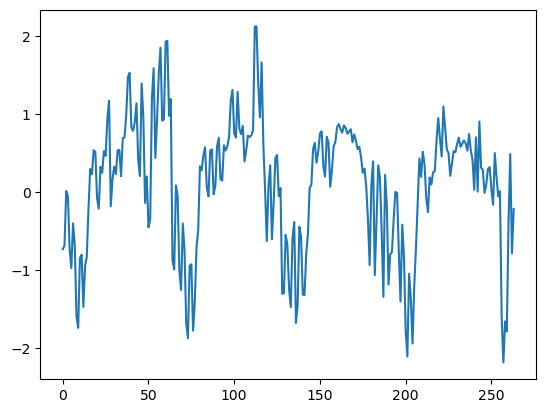

In [14]:
plt.plot(((X - X.mean(dim=['time', 'ncol'])) / X.std(dim=['time', 'ncol'])).state_t.isel(time=125, lev=55).values) # a lot of spatial variance

In [15]:
def normalize(xarr):
    var_means = xarr.mean(dim=['time', 'ncol'])
    var_stds = xarr.std(dim=['time', 'ncol'])
    arr = (xarr - var_means) / var_stds
    
    means = []
    stds = []
    for var in arr.data_vars:
        means.append(var_means[var].values.reshape(-1, 1))
        stds.append(var_stds[var].values.reshape(-1, 1))
    return(arr, np.vstack(means)[:, 0], np.vstack(stds)[:,0])

class MyDataset(Dataset):
    def __init__(self, ds, device = "cuda" if torch.cuda.is_available() else "cpu"):
        self.ds = ds
        self.X_ds, self.Y_ds = split_input_output(ds)
        self.device = device
        
        self.X_norm, self.X_mean, self.X_std = normalize(self.X_ds)
        self.Y_norm, self.Y_mean, self.Y_std = normalize(self.Y_ds)
        
    def __len__(self):
        return( self.ds.time.size * self.ds.ncol.size )
    
    def __getitem__(self, idx):
        t, col = idx // self.ds.ncol.size, idx % self.ds.ncol.size
        X = self.X_norm.isel(time=t, ncol=[col])
        Y = self.Y_norm.isel(time=t, ncol=[col])
        
        X = X.to_stacked_array("v", sample_dims=["ncol"]).values
        Y = Y.to_stacked_array("v", sample_dims=["ncol"]).values
        
        # Normalize sample so that each value is within -1-1 range. Thus, across samples but each independent iid
        #X = (X - self.X_mean) / self.X_std
        #Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
        
        X = torch.as_tensor(X, device=self.device, dtype=torch.float32)
        Y = torch.as_tensor(Y, device=self.device, dtype=torch.float32)
        return(X.squeeze(), Y.squeeze())

In [146]:
%%time
dataset = MyDataset(train)
dataloader = DataLoader(dataset, batch_size=, shuffle=True)

CPU times: user 3.14 s, sys: 1.27 s, total: 4.41 s
Wall time: 4.43 s


torch.Size([124]) torch.Size([122]) 



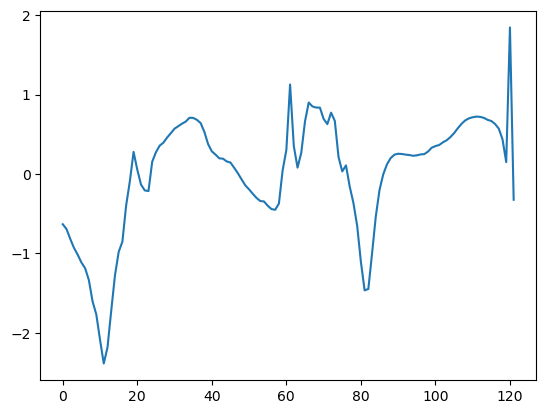

CPU times: user 257 ms, sys: 121 ms, total: 379 ms
Wall time: 170 ms


In [135]:
%%time
i = 10
X_norm, Y_norm = dataset[i]
print(X_norm.shape, Y_norm.shape, '\n')
plt.plot(Y_norm.cpu().numpy())
plt.show()

In [136]:
# can reconstruct via stored means
X_rec = dataset.X_mean + X_norm.cpu().numpy() * dataset.X_std
print(X_rec[-4:])
X.isel(time=0, ncol=i)

[ 4.78904971e+02  6.05950839e+00 -9.72814166e-01  1.00134432e+05]


<xarray.Dataset>
Dimensions:      (lev: 60)
Coordinates:
    time         object 0001-02-01 12:00:00
    ncol         int64 10
    lat          float64 -28.03
    lon          float64 5.68
Dimensions without coordinates: lev
Data variables:
    state_q0001  (lev) float64 1.523e-06 1.502e-06 1.46e-06 ... 0.0103 0.01245
    state_t      (lev) float64 216.5 233.8 236.7 246.0 ... 297.6 297.7 296.8
    pbuf_SOLIN   float64 478.9
    pbuf_LHFLX   float64 6.06
    pbuf_SHFLX   float64 -0.9728
    state_ps     float64 1.001e+05
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [141]:
%%time
X_sample, Y_sample = next(iter(dataloader))
print(X_sample.shape, Y_sample.shape, '\n')

torch.Size([32, 124]) torch.Size([32, 122]) 

CPU times: user 1.83 s, sys: 31.4 ms, total: 1.86 s
Wall time: 1.26 s


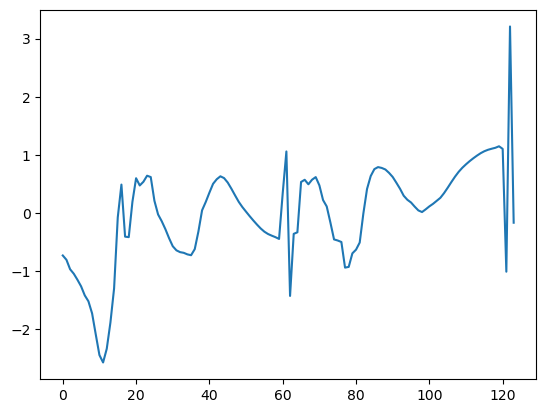

In [138]:
plt.plot(X_sample[1, :].cpu())

## Define Model

In [142]:
from tools import progress

class VariationalEncoder(torch.nn.Module):
    """
    Conditional VAE Encoder with <layers>+1 fully connected layer
    """
    def __init__(self, in_dims, hidden_dims=[128, 128, 64, 32], latent_dims=5, layers=4, dropout=0, device='cuda'):
        super().__init__()
        self.linears = [torch.nn.Sequential(
                torch.nn.Linear(in_dims, hidden_dims[0]),
                torch.nn.LayerNorm(hidden_dims[0]),
                torch.nn.Dropout(p=dropout))]
        self.add_module('linear0', self.linears[-1])
        for i in range(1, layers):
            self.linears += [torch.nn.Sequential(
                torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]),
                torch.nn.LayerNorm(hidden_dims[i]),
                torch.nn.Dropout(p=dropout))
                ]
            self.add_module('linear%d' % i, self.linears[-1])
        self.linear_mean = torch.nn.Linear(hidden_dims[-1], latent_dims)
        self.linear_logstd = torch.nn.Linear(hidden_dims[-1], latent_dims) # log of actual, later exponentiate

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        
        self.device = device

    def forward(self, x, return_latent=False):
        y = torch.flatten(x, start_dim=1)
        for linear in self.linears:
            y = torch.nn.functional.relu(linear(y))
        mu = self.linear_mean(y) # mu is g(l(x))
        if return_latent:
            return mu
        else:
            sigma = torch.exp(self.linear_logstd(y)) # sigma is h(l(x))
            z = mu + sigma * self.N.sample(mu.shape) # reparameterization trick
            self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean()
            return z


class Decoder(torch.nn.Module):
    """
    Conditional VAE Decoder with <layers>+1 fully connected layer
    """
    def __init__(self, out_dims, hidden_dims=[32, 64, 128, 128], latent_dims=3, layers=4, dropout=0):
        super().__init__()
        self.linears = [torch.nn.Sequential(
                torch.nn.Linear(latent_dims, hidden_dims[0]),
                torch.nn.LayerNorm(hidden_dims[0]),
                torch.nn.Dropout(p=dropout))]
        self.add_module('linear0', self.linears[-1])
        
        for i in range(1, layers):
            self.linears += [torch.nn.Sequential(
                torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]),
                torch.nn.LayerNorm(hidden_dims[i]),
                torch.nn.Dropout(p=dropout))
                ]
            self.add_module('linear%d' % i, self.linears[-1])        

        self.final_linear1 = torch.nn.Linear(hidden_dims[-1], out_dims)
        # self.final_linear2 = torch.nn.Linear(hidden_dims, out_dims)
        self.final_log_std1 = torch.nn.Linear(hidden_dims[-1], out_dims)
        # self.final_log_std2 = torch.nn.Linear(hidden_dims, out_dims)
        # self.final_lambda = torch.nn.Linear(hidden_dims, 1)
        # self.final_prob_zero = torch.nn.Linear(hidden_dims, out_dims)

    def forward(self, z): # outputs distribution
        for linear in self.linears:
            z = torch.nn.functional.relu(linear(z))
        m1 = self.final_linear1(z)
        # m2 = self.final_linear2(z)
        s1 = torch.exp(self.final_log_std1(z))
        # s2 = torch.exp(self.final_std2(z))
        # lam = self.final_lambda
        # p0 = torch.sigmoid(self.final_prob_zero(z))
        return m1, s1


class VariationalEncoderDecoder(torch.nn.Module):
    def __init__(self, beta=0.01, data_dims=124, label_dims=128,
                 latent_dims=5, hidden_dims_input=[128, 128, 64, 32], hidden_dims_output = [32, 64, 128, 128], dropout=0, device='cuda'):
        """
        Conditional VAE
        Encoder: [y x] -> [mu/sigma] -sample-> [z]
        Decoder: [z x] -> [y_hat]

        Inputs:
        -------
        beta - [float] trade-off between KL divergence (latent space structure) and reconstruction loss
        data_dims - [int] size of x
        label_dims - [int] size of y
        latent_dims - [int] size of z
        hidden_dims - [list::int] size of each hidden layers, for both input and output
        layers - [int] number of layers, including hidden layer
        
        """
        super().__init__()
        self.data_dims = data_dims
        self.label_dims = label_dims
        self.latent_dims = latent_dims
        self.label_dims = label_dims
        # Encoder - compresses data into latent dims
        self.encoder = VariationalEncoder(data_dims, hidden_dims_input, latent_dims, layers=len(hidden_dims_input), dropout=dropout, device=device).to(device)
        # Decoder - tries to learn both input and output variables. 
        self.decoder = Decoder(label_dims + data_dims, hidden_dims_output, latent_dims, layers=len(hidden_dims_output), dropout=dropout).to(device)
        self.beta = beta
        self.device = device

    def forward(self, x, y, return_latent=False, batch_norm=False):
        # expect to be batch_size x data_dims matrix and y to be batch_size x label_dims matrix
        
        # Normalize
        if batch_norm:
            x_m, x_s = x.mean(axis=0), x.std(axis=0)
            y_m, y_s = y.mean(axis=0), y.std(axis=0)
            mx, my = x_s != 0, y_s != 0
            x[:, mx] = x[:, mx] / x_s[mx] - x_m[mx]
            y[:, my] = y[:, my] / y_s[my] - y_m[my]
        z = self.encoder(x, return_latent)
        if return_latent:
            return z
        else:
            y_hat_mean, y_hat_std = self.decoder(z)
            if batch_norm:
                y_hat_mean = (y_hat_mean + y_m) * y_s # undo the batch norm for output
            return y_hat_mean, y_hat_std

    def sample(self, batch_size, random=True):
        """
        Sample from uniform Normal Distribution

        Inputs:
        -------
        x - [BxN array] label
        random - [boolean] if true sample latent variable from prior else use all-zero vector
        """
        if random:
            # Draw from prior
            z = self.encoder.N.sample([batch_size, self.latent_dims])
        else:
            # Set to prior mean, 0 (standard N)
            z = torch.zeros([batch_size, self.latent_dims]).to(self.device)
        mean_y, std_y = self.decoder(z)
        if random:
            # add output noise
            y = mean_y + self.encoder.N.sample(mean_y.shape) * std_y
            # y = torch.zeros_like(mean_y)
            # nz = torch.rand(y.shape).to(self.device) > p0
            # y[nz] = mean_y[nz] + self.encoder.N.sample([(nz == 1).sum()]) * std_y[nz]
            return y
        else:
            return mean_y, std_y

    def trainer(self, data, save_params, train_params):
        """
        Train the Conditional VAE

        Inputs:
        -------
        data - [DataLoader] - training data
        epochs - [int] number of epochs
        loss_type - [str] type of loss
        optimizer - [str] type of optimizer
        lr - [float] learning rate
        weight_decay - [float] L2 regularization
        save - [str] file path to save trained model to after training (and after every 20 minutes)
        plot - [boolean] if plots of loss curves and samples should be produced
        """
        
        
        # Training parameters
        if train_params['optimizer'] == 'adam':
            opt = torch.optim.Adam(self.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
        elif train_params['optimizer'] == 'sgd':
            opt = torch.optim.SGD(self.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
        else:
            raise ValueError('Unknown optimizer')

        # Train and checkpoint every 20 minutes
        
        if(save_params['save']):
            # calls lambda function every 1200 seconds and at the end
            path = os.path.join(save_params['model_path'], save_params['name']) + ".pt"
            timed=[(save_params['save_interval'], lambda: torch.save(self.state_dict(), path))]
        else:
            timed = None
        
        losses = []
        for epoch, (x,y) in progress(range(train_params['epochs']), inner=data, text='Training', timed=timed):
            x = x.to(self.device)
            y = y.to(self.device)
            O_real = torch.cat([x, y], 1).to(self.device) # actual output desired 
            opt.zero_grad() # VERY IMPORTANT! Reset gradients. 
            
            O_mean, O_std = self(x, y)
            #y_mean, y_std = self(y, x)
            # y_mean, y_std, p0 = self(y, x)
            if train_params['loss_type'] == 'mse':
                # iid gaussians -> mse
                # loss = ((y - y_hat) ** 2).sum() / self.label_dims + self.beta * self.encoder.kl / self.latent_dims

                # means, so beta' = beta * label_dims / latent_dims
                
                rec_loss = 0.5 * (O_real - O_mean) ** 2 + torch.log(O_std)
                loss = rec_loss.mean() + self.beta * self.encoder.kl
                #loss = (0.5 * (y - y_mean) ** 2 / y_std + torch.log(y_std)).mean() + self.beta * self.encoder.kl
                # model as p0 * N(0, 1/1000) + (1-p0) * N(mean, std)
                # loss = (p0 * y**2).sum() + ((1 - p0) * ((y - y_mean) ** 2 / y_std + torch.log(y_std))).mean() + self.beta * self.encoder.kl
            else:
                raise ValueError('Unknown loss')

            torch.clip(loss, min=-1e5, max=1e5).backward() # backpropagate loss
            losses += [loss.item()]
            opt.step()
        print('Last-epoch loss: %.2f' % sum(losses[-len(data):-1]))
        print('Finished Training')

        if save_params['plot']:
            fig_path = os.path.join(save_params['figure_path'], save_params['name'])
            O_hat = O_mean + self.encoder.N.sample([x.shape[0], self.data_dims + self.label_dims]) * O_std
            plt.plot(np.array(losses)[:-1])
            if save_params['savefig']:
                plt.savefig(f'{fig_path}/loss.png')
            fig, ax = plt.subplots(4, 1, sharey=True, figsize=(12, 8))
            ax[0].plot((O_real[0:500] - O_mean[0:500]).detach().cpu().numpy().T, c="C0", alpha=0.3)
            ax[1].plot((O_real[0:500] - O_hat[0:500]).detach().cpu().numpy().T, c="C0", alpha=0.3)
            ax[2].plot((O_real[0:500] - self.sample(O_real.shape[0])).detach().cpu().numpy().T, c="C0", alpha=0.3)
            ax[3].plot((O_real[0:500] - self.sample(O_real.shape[0], random=False)[0]).detach().cpu().numpy().T, c="C0", alpha=0.3)
            ax[0].set_ylabel('y - reconstructed sample')
            ax[1].set_ylabel('y - reconstructed mean')
            ax[2].set_ylabel('y - random sample')
            ax[3].set_ylabel('y - mean')
            ax[0].set_ylim([-0.5, 0.5])
            plt.tight_layout()
            if save_params['savefig']:
                plt.savefig(f'{fig_path}/last_batch.png')
            plt.show()
            plt.close('all')
        return(losses)

### Make Sure Model works

In [117]:
class FakeDataset(Dataset):
    def __init__(self, insize, outsize):
        self.insize = insize
        self.outsize = outsize
        self.device = model_params['device']
        
    def __len__(self):
        return( 100 )
    
    def __getitem__(self, idx):
        return(torch.ones(self.insize, device=self.device), torch.ones(self.outsize, device=self.device))
fake_dataset = FakeDataset(124, 122)
fake_dataloader = DataLoader(fake_dataset, batch_size=train_params['batch_size'], shuffle=True)
x, y = fake_dataset[0]

In [143]:
save_params = {
    'name' : 'ved_test1',
    'plot' : True,
    'save' : True,
    'model_path' : "saved_data/models", 
    'savefig' : True,
    'save_interval' : 1200,
    'figure_path' : 'saved_data/figures',
    
}

train_params = {
    'epochs' : 20,
    'loss_type' : 'mse',
    'optimizer' : 'adam',
    'lr' : 0.0001,
    'weight_decay' : 0,
    'batch_size' : 64, 
}

model_params = {'beta': 0.02,
     'data_dims': 124,
     'label_dims': 122,
     'latent_dims': 6,
     'input_layers': [128, 128, 64, 64, 32],
     'output_layers': [32, 64, 64, 128, 128],
     'dropout': 0.05,
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
}

In [118]:
model = VariationalEncoderDecoder(model_params['beta'], model_params['data_dims'], model_params['label_dims'], 
        model_params['latent_dims'], model_params['input_layers'], model_params['output_layers'], model_params['dropout'], model_params['device'])


In [119]:
x, y = next(iter(fake_dataloader))
Omu, Osigma = model(x, y)
print(Omu.shape)
print(Osigma.shape)

torch.Size([64, 246])
torch.Size([64, 246])


In [102]:
z = model(x, y, return_latent=True)
z[1:5, :]

tensor([[-0.2648,  0.0808, -0.3175,  0.4105, -0.0259,  0.3819],
        [-0.4083,  0.0997, -0.4062,  0.7423,  0.0396,  0.2870],
        [-0.2939,  0.4832, -0.3217,  0.3434, -0.0588,  0.4399],
        [-0.2746,  0.3503, -0.5668,  0.3311, -0.2858,  0.3703]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [97]:
model.sample(32).shape

torch.Size([32, 246])

Training [100.0 %] - 20 / 20 (2 / 2) - 0.4s [TBD: 0.0s]
Last-epoch loss: 0.08
Finished Training


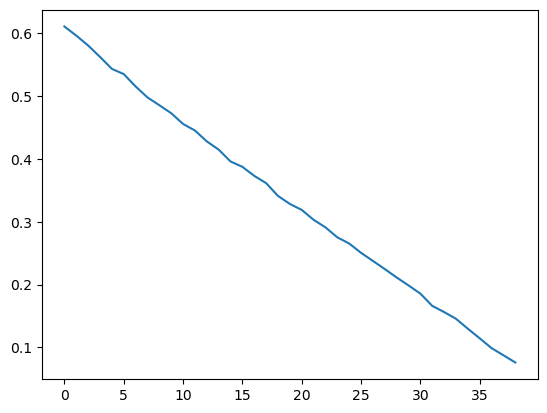

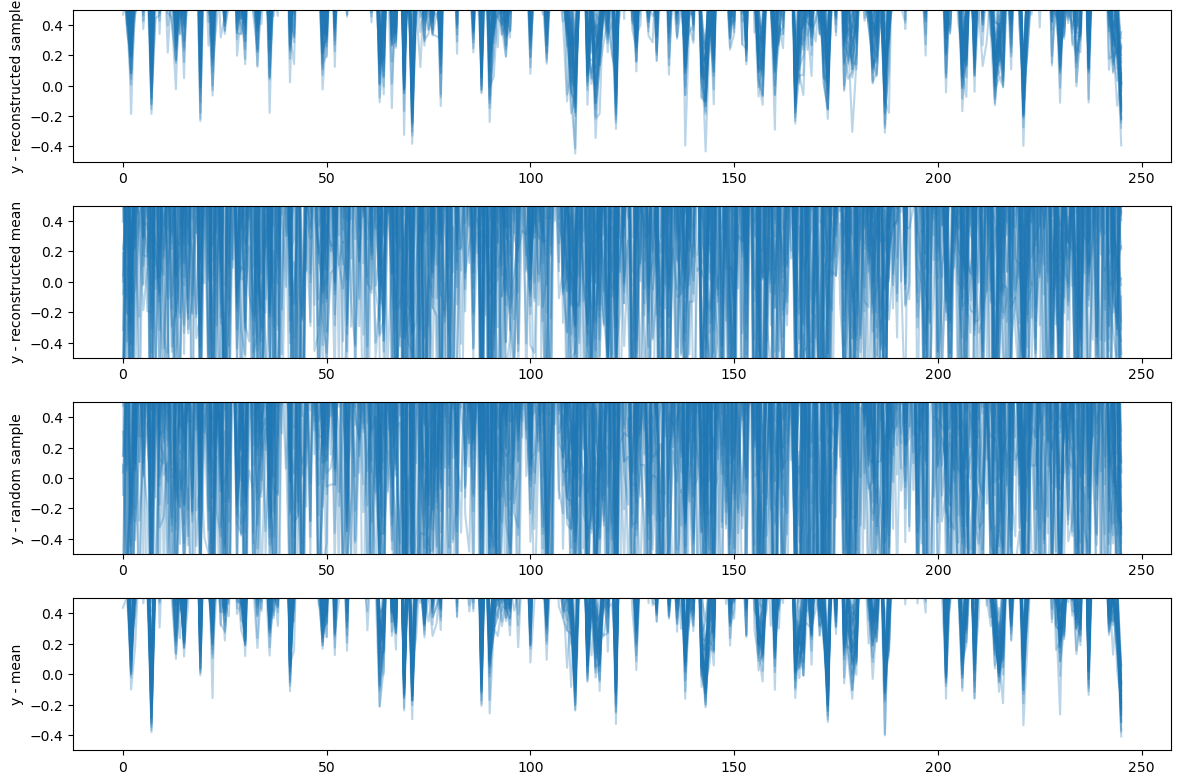

In [121]:
losses = model.trainer(fake_dataloader, save_params, train_params)

# Train and Evaluate Model

In [78]:
#from Architectures.VED import VariationalEncoderDecoder

In [48]:
save_params = {
    'name' : 'ved_test1',
    'plot' : True,
    'save' : True,
    'model_path' : "saved_data/models", 
    'filetype' : '.pt',
    'savefig' : True,
    'save_interval' : 600,
    'figure_path' : 'saved_data/figures',
    
}

train_params = {
    'epochs' : 20,
    'loss_type' : 'mse',
    'optimizer' : 'adam',
    'lr' : 0.0001,
    'weight_decay' : 0,
    'batch_size' : 64, 
}

model_params = {'beta': 0.02,
     'data_dims': 124,
     'label_dims': 122,
     'latent_dims': 6,
     'input_layers': [128, 128, 64, 64, 32],
     'output_layers': [32, 64, 64, 128, 128],
     'dropout': 0.05,
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
}

In [144]:
model = VariationalEncoderDecoder(
    model_params['beta'], model_params['data_dims'], model_params['label_dims'], model_params['latent_dims'], 
    model_params['input_layers'], model_params['output_layers'], model_params['dropout'], model_params['device']
)

In [148]:
dataset = MyDataset(train)
dataloader = DataLoader(dataset, batch_size=train_params['batch_size'], shuffle=False)

In [47]:
#    def trainer(self, data, epochs=20, save="models/ved.cp", plot=True, loss_type='mse',
#                optimizer='adam', lr=0.0001, weight_decay=0, savefig=False):
#losses = model.trainer(dataloader, save_params, train_params)

In [7]:
import json
def save_model():
    path = os.path.join(save_params['model_path'], save_params['name'])
    torch.save(model.state_dict(), path + save_params['filetype'])
    
    params = {
        'training_parameters' : train_params, 
        'model_parameters' : model_params, 
        'save_parameters' : save_params,
    }
    
    with open(path + ".json", 'w', encoding='utf-8') as f:
        json.dump(params, f, ensure_ascii=False, indent=4) 
    

In [46]:
path = os.path.join(save_params['model_path'], save_params['name'])
with open(path + ".json", 'w', encoding='utf-8') as f:
    json.dump(params, f, ensure_ascii=False, indent=4) 

In [43]:
params['save parameters']['filetype'] = '.pt'

In [44]:
params['save parameters']['filetype']

'.pt'

In [34]:
path = os.path.join(save_params['model_path'], save_params['name'])

In [35]:
json.load(open(path + '.json'))

{'training_parameters': {'epochs': 20,
  'loss_type': 'mse',
  'optimizer': 'adam',
  'lr': 0.0001,
  'weight_decay': 0,
  'batch_size': 64},
 'model parameters': {'architecture': 'VED',
  'beta': 0.02,
  'data_dims': 124,
  'label_dims': 122,
  'latent_dims': 6,
  'input_layers': [128, 128, 64, 64, 32],
  'output_layers': [32, 64, 64, 128, 128],
  'dropout': 0.05,
  'device': 'cuda'},
 'save parameters': {'name': 'ved_test1',
  'plot': True,
  'save': True,
  'model_path': 'saved_data/models',
  'savefig': True,
  'save_interval': 600,
  'figure_path': 'saved_data/figures'}}

In [ ]:
"""
model = ConditionalVAE(beta=0.01, data_dims=62, label_dims=62,
                 latent_dims=3, hidden_dims=512, layers=2, dropout=0).to(device)


model.trainer(dataloader, epochs=2, save="models/vae.cp", plot=True, loss_type='mse',
                optimizer='adam', lr=0.0001, weight_decay=0)
""" 

In [ ]:
(beta=0.01, data_dims=62, label_dims=62,
                 latent_dims=3, hidden_dims=512, layers=2, dropout=0)

In [20]:
train_params

{'epochs': 20,
 'loss_type': 'mse',
 'optimizer': 'adam',
 'lr': 0.0001,
 'weight_decay': 0,
 'batch_size': 64}

In [40]:
model_params_cvae = {
    'architecture': 'cVAE',
    'beta': 0.01,
    'data_dims': 62,
    'label_dims': 62,
    'latent_dims': 3,
    'hidden_dims': 512,
    'layers': 2,
    'dropout': 0.0,
    'device': 'cuda'
}
train_params_cvae = {'epochs': 2,
 'loss_type': 'mse',
 'optimizer': 'adam',
 'lr': 0.0001,
 'weight_decay': 0,
 'batch_size': 32}
save_params_cvae = dict(name="vae", model_path='saved_data/models', filetype='.cp')

In [41]:
params_c = {
    'training_parameters' : train_params_cvae, 
    'model parameters' : model_params_cvae, 
    'save parameters' : save_params_cvae,
}

path = os.path.join(save_params_cvae['model_path'], save_params_cvae['name'])
with open(path + ".json", 'w', encoding='utf-8') as f:
    json.dump(params_c, f, ensure_ascii=False, indent=4) 

In [50]:
batch_size = 32
in_dims = 62
out_dims = 54
x = 2 * np.ones((batch_size, in_dims))
y = np.zeros((batch_size, out_dims))

x = torch.tensor(x)
y = torch.tensor(y)

xy = torch.cat([x, y], 1)
xy.shape

torch.Size([32, 116])